In [1]:
from __future__ import print_function

import sys

sys.path.extend(['/home/jorg/repository/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm

from datetime import datetime
from pytz import timezone
import copy

import numpy as np
import torch

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import ACDC2017DataSet
from in_out.detector.detector_dataset import RegionDetectorDataSet
from config.config import config as config_acdc
from common.detector.config import config_detector
from plotting.color_maps import transparent_cmap
from plotting.seg_errors_and_maps import plot_slices
from utils.exper_hdl_ensemble import ExperHandlerEnsemble
from common.detector.box_utils import find_bbox_object, BoundingBox
from utils.detector.batch_handler import BatchHandler
from utils.detector.experiment import Experiment
from utils.detector.exper_handler import ExperimentHandler

mycmap = transparent_cmap(plt.get_cmap('jet'))

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Constants aka fixed variables
ROOT_DIR = "/home/jorg/repository/dcnn_acdc"

# set seeds
SEED = 4325
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic = True
np.random.seed(SEED)

# Load our baseline 
seg_exper_ensemble = ExperHandlerEnsemble(config_detector.exper_dict_brier)

Load experiment from /home/jorg/repository/dcnn_acdc/logs/ACDC/20180418_15_02_05_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['0'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/ACDC/20180426_14_13_46_dcnn_mc_f1p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['1'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/ACDC/20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['2'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/ACDC/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['3'] loss=brier


In [17]:
fold_id = 0
exper_handler = seg_exper_ensemble.seg_exper_handlers[fold_id]

exper_handler.generate_dt_maps()
exper_handler.generate_target_rois_for_learning(mc_dropout=True)


In [3]:
fold_id = 0

seg_exper_ensemble.prepare_handlers(fold_id=0, type_of_map="e_map", for_detector_dtaset=False, 
                                    load_dt_roi_maps=False)
exper_handler = seg_exper_ensemble.seg_exper_handlers[fold_id]

## Convert segmentation masks (error rois) to nii format for MeVisLab

In [12]:
exper_handler.write_masks_to_disk(type_of_mask="detect_roi", type_of_map="emap")

100%|██████████| 25/25 [00:07<00:00,  3.21it/s]


## Statistics w.r.t. error rois = seg-errors we want our detector to identify

In [3]:
fold_id = 0
exper_handler = seg_exper_ensemble.seg_exper_handlers[fold_id]
_ = exper_handler.get_target_roi_maps(mc_dropout=False)
_ = exper_handler.get_pred_labels(mc_dropout=False, force_reload=False)
exper_handler.get_test_set()

100%|██████████| 25/25 [00:04<00:00,  6.14it/s]


In [6]:
def compute_roi_error_stats(error_roi_volume, slice_id_error_counts, location_error_counts, cardiac_phase):
    # cardiac_phase: 0 = ES and 1 = ED
    # error_roi_volume has shape [#classes, w, h, #slices]
    error_per_cls_slice = np.sum(error_roi_volume, axis=(1, 2))
    num_of_slices = error_roi_volume.shape[3]
    check_patient = False
    # Base, slice=0
    if np.any(error_per_cls_slice[:, 0] != 0):
        check_patient = True
        slice_id_error_counts[cardiac_phase, 0] += 1
        location_error_counts[cardiac_phase, 0] += np.sum(error_per_cls_slice[:, 0])
    if np.any(error_per_cls_slice[:, num_of_slices-1] != 0):
        check_patient = True
        slice_id_error_counts[cardiac_phase, 2] += 1
        location_error_counts[cardiac_phase, 2] += np.sum(error_per_cls_slice[:, num_of_slices-1])
    # slices in-between base-apex
    if np.any(error_per_cls_slice[:, 1:num_of_slices-1] != 0):
        check_patient = True
        slice_id_error_counts[cardiac_phase, 1] +=  np.count_nonzero(np.sum(error_per_cls_slice[:, 1:num_of_slices-1], axis=0))
        location_error_counts[cardiac_phase, 1] += np.sum(error_per_cls_slice[:, 1:num_of_slices-1])
        
    return slice_id_error_counts, location_error_counts, check_patient


# count the overall errors and separate for base/middle/apex: index0 ES/ED, index1: 0=base, 1=middle, 2=apex
location_error_counts = np.zeros((2, 3))
total_num_of_patients, total_num_of_slices, num_patients_no_check = 0, 0, 0
slice_id_error_counts = np.zeros((2, 3))

# count the errors to be detected and separate for base/middle/apex: index0 ES/ED, index1: 0=base, 1=middle, 2=apex
det_location_error_counts = np.zeros((2, 3))
det_slice_id_error_counts = np.zeros((2, 3))
# store roi sizes per base, mid, apex for ES (0) and ED (1)
det_roi_size_per_location = {0: [[], [], []], 1: [[], [], []]}

c_roi_es, c_roi_ed = 0, 0
c_total_es, c_total_ed = 0, 0

for p_id, roi_volume in exper_handler.target_roi_maps.iteritems():
    # split in ES and ED
    num_of_slices = roi_volume.shape[3]
    total_num_of_slices += num_of_slices
    total_num_of_patients += 1
    _, labels = exper_handler.test_set.get_test_pair(patient_id=p_id)
    pred_labels = exper_handler.pred_labels[p_id]
    error_volume = labels != pred_labels
    error_volume_es, error_volume_ed = error_volume[0:4], error_volume[4:]
    roi_volume_es, roi_volume_ed = roi_volume[0:4], roi_volume[4:]
    c_roi_es += np.sum(roi_volume_es)
    c_roi_ed += np.sum(roi_volume_ed)
    c_total_es += np.sum(error_volume_es)
    c_total_ed += np.sum(error_volume_ed)
    # roi_volumes_es/ed have [4, w, h, #slices]
    det_slice_id_error_counts, det_location_error_counts, check_patient_es = \
    compute_roi_error_stats(roi_volume_es, det_slice_id_error_counts, det_location_error_counts, cardiac_phase=0)
    det_slice_id_error_counts, det_location_error_counts, check_patient_ed = \
    compute_roi_error_stats(roi_volume_ed, det_slice_id_error_counts, det_location_error_counts, cardiac_phase=1)
    if not check_patient_es and not check_patient_ed:
        num_patients_no_check += 1
    slice_id_error_counts, location_error_counts, _ = \
    compute_roi_error_stats(error_volume_es, slice_id_error_counts, location_error_counts, cardiac_phase=0)
    slice_id_error_counts, location_error_counts, _ = \
    compute_roi_error_stats(error_volume_ed, slice_id_error_counts, location_error_counts, cardiac_phase=1)
    

print("Total #patients={}, #slices={}".format(total_num_of_patients, total_num_of_slices))
print("Overall {}/{}".format(c_total_es, c_total_ed))
print(slice_id_error_counts)  
print(location_error_counts)
print("Error roi stats {}/{}".format(c_roi_es, c_roi_ed))
print(det_slice_id_error_counts)  
print(det_location_error_counts)
print("{:.2f} % of patients ({}) to check".format((100 - (100 * num_patients_no_check/float(total_num_of_patients))), 
                                                 total_num_of_patients))

Total #patients=25, #slices=228
Overall 135801/117456
[[  24.  178.   25.]
 [  25.  178.   25.]]
[[  25599.  103043.    7159.]
 [  20587.   88703.    8166.]]
Error roi stats 10505.0/3889.0
[[ 14.  74.  15.]
 [ 12.  47.  12.]]
[[ 6017.  3782.   706.]
 [ 1796.  1400.   693.]]
96.00 % of patients (25) to check


In [5]:
print(np.sum(det_location_error_counts, axis=1))
print(np.sum(location_error_counts, axis=1))
perc_location_errors = det_location_error_counts * 1./location_error_counts * 100
print(perc_location_errors)
print(np.mean(perc_location_errors, axis=1))

[ 10505.   3889.]
[ 135801.  117456.]
[[ 23.50482441   3.67031239   9.86171253]
 [  8.72395201   1.57830062   8.48640705]]
[ 12.34561644   6.26288656]


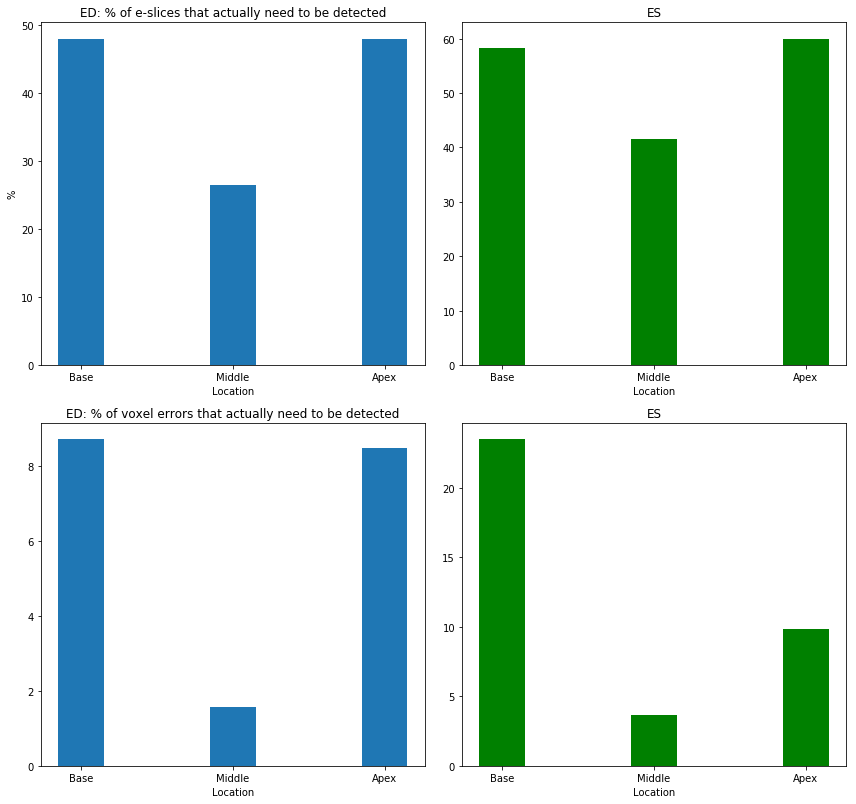

In [6]:
from matplotlib.ticker import FuncFormatter, MaxNLocator

x_values = np.array([0,1,2])
x_labels = ["Base", "Middle", "Apex"]

def format_fn(tick_val, tick_pos):
    if int(tick_val) in x_values:
        return x_labels[int(tick_val)]
    else:
        return ''
    
width, height = 12, 12
fig = plt.figure(figsize=(width, height))

perc_slice_location = det_slice_id_error_counts * 1./slice_id_error_counts * 100

perc_location_errors = det_location_error_counts * 1./location_error_counts * 100

ax1 = plt.subplot2grid((4, 4), (0, 0), rowspan=2, colspan=2)
ax1.bar(x_values, perc_slice_location[1], width=0.3)
ax1.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_xlabel("Location")
ax1.set_ylabel("%")
ax1.set_title("ED: % of e-slices that actually need to be detected")
ax2 = plt.subplot2grid((4, 4), (0, 2), rowspan=2, colspan=2)
ax2.bar(x_values, perc_slice_location[0], width=0.3, color="g")
ax2.set_xlabel("Location")
ax2.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_title("ES")

ax3 = plt.subplot2grid((4, 4), (2, 0), rowspan=2, colspan=2)
ax3.bar(x_values, perc_location_errors[1], width=0.3)
ax3.set_xlabel("Location")
ax3.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax3.xaxis.set_major_locator(MaxNLocator(integer=True))
ax3.set_title("ED: % of voxel errors that actually need to be detected")

ax4 = plt.subplot2grid((4, 4), (2, 2), rowspan=2, colspan=2)
ax4.bar(x_values, perc_location_errors[0], width=0.3, color='g')
ax4.set_xlabel("Location")
ax4.xaxis.set_major_formatter(FuncFormatter(format_fn))
ax4.xaxis.set_major_locator(MaxNLocator(integer=True))
ax4.set_title("ES")

fig.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

## Visualize a patient volume 

Left column overlays = uncertainties or error rois
Right column overlays = automatic segmentation masks (default), references (ref), segmentation errors (errors)

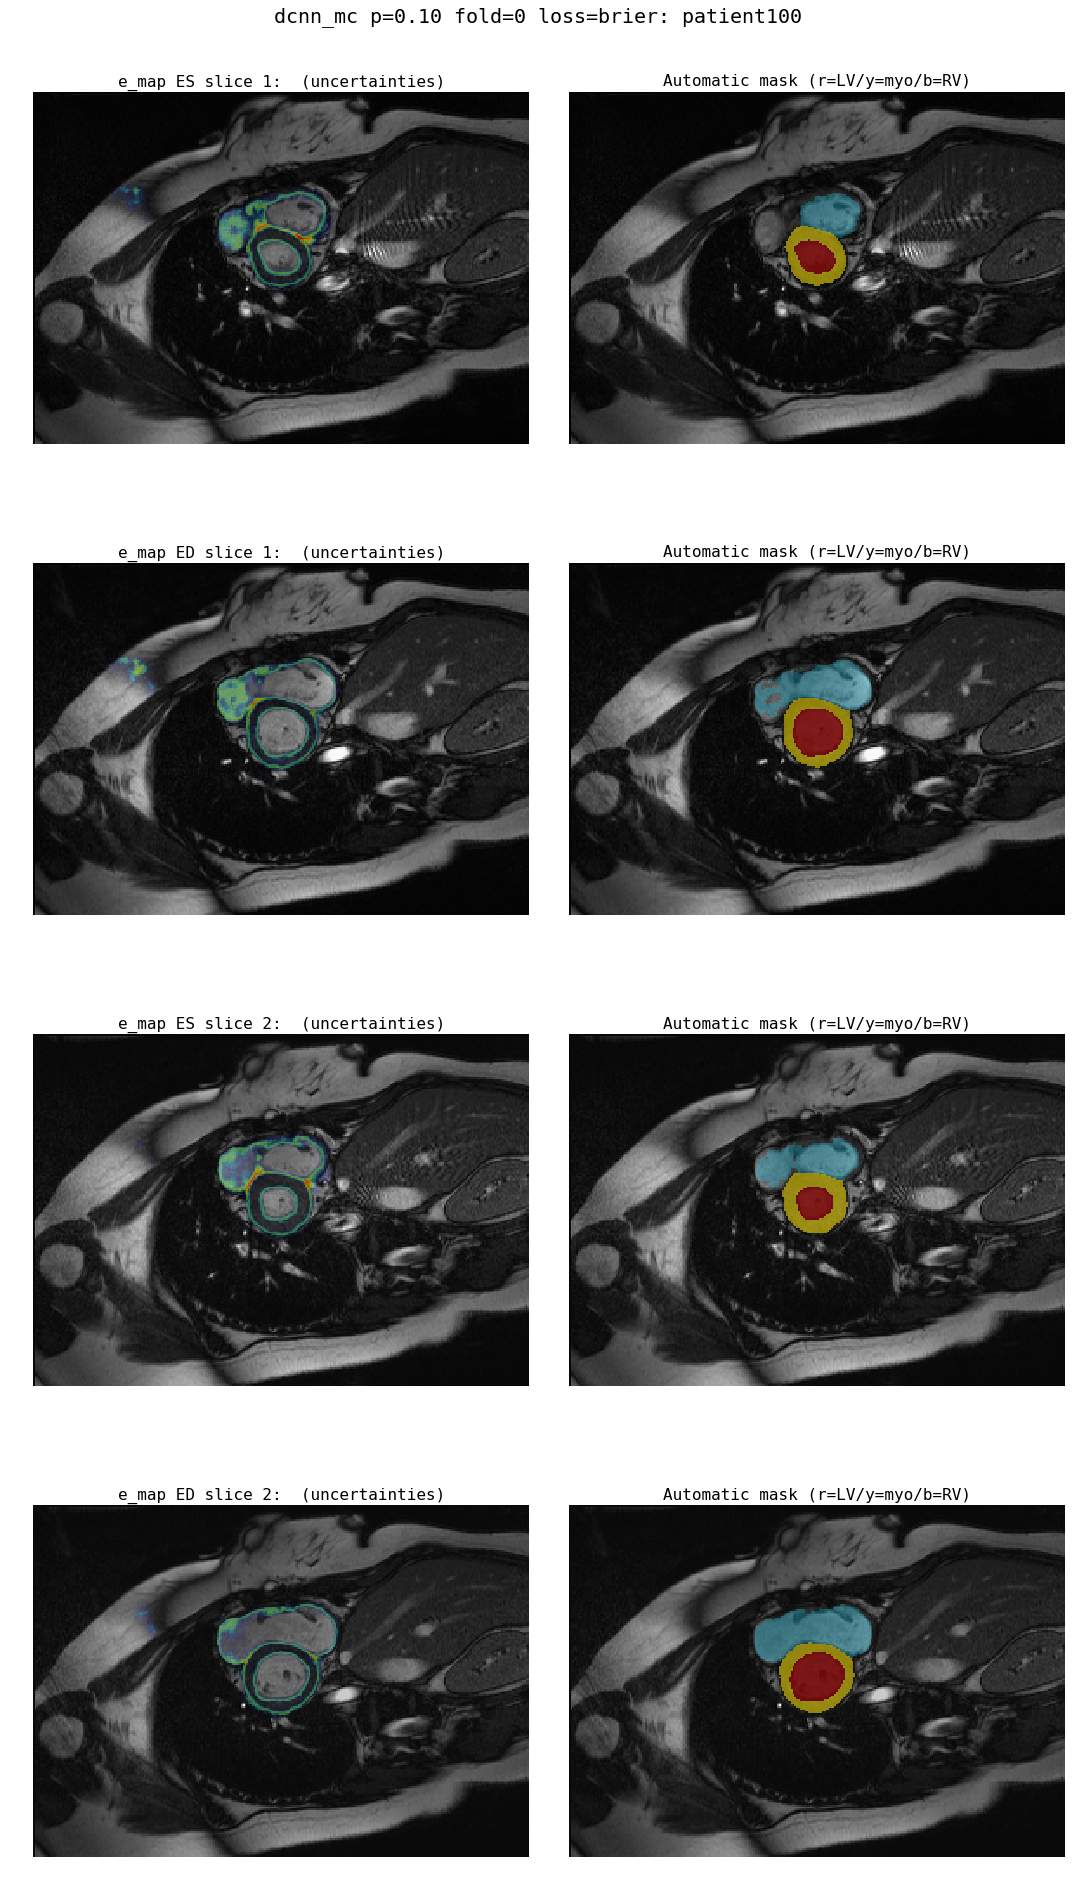

In [21]:
fold_id = 0
patient_id = "patient100"
exper_handler = seg_exper_ensemble.seg_exper_handlers[fold_id]

# left_column_overlay = [None, "map", "error_roi"]   right_column_overlay=[None, "error", "ref", "auto"]
plot_slices(exper_handler, patient_id=patient_id, do_show=True, do_save=False, threshold=None, 
            slice_range=[0, 2], type_of_map="e_map", aggregate_func="max", right_column_overlay="auto",
            left_column_overlay="map")